# 1) Importing Libraries

In [1]:
import cv2
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp
import tensorflow as tf
from scipy import stats
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [2]:
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_built_with_cuda())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


# 2) Generating Key Points Using MP Holistic

In [3]:
mp_holistic = mp.solutions.holistic # Holistic Model : to make detecctions
mp_drawing = mp.solutions.drawing_utils # Drawing utilities : to draw the detections

In [4]:
def mediapipe_detection (image,model):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) # Converting the image from cv2 feed to RGB as mediapipe uses image in RGB format
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # Converting the Image back to its orginal format of BGR
    return image, results

In [5]:
def draw_styled_landmarks(image,results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [6]:
# Setting up the Mediapipe model
cap =cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret,frame = cap.read()
        image,results = mediapipe_detection(frame,holistic)   
        draw_styled_landmarks(image,results)
        cv2.imshow("Open CV Feed",image)
        if cv2.waitKey(10) & 0xFF == ord("q"):
            break
cap.release()
cv2.destroyAllWindows()

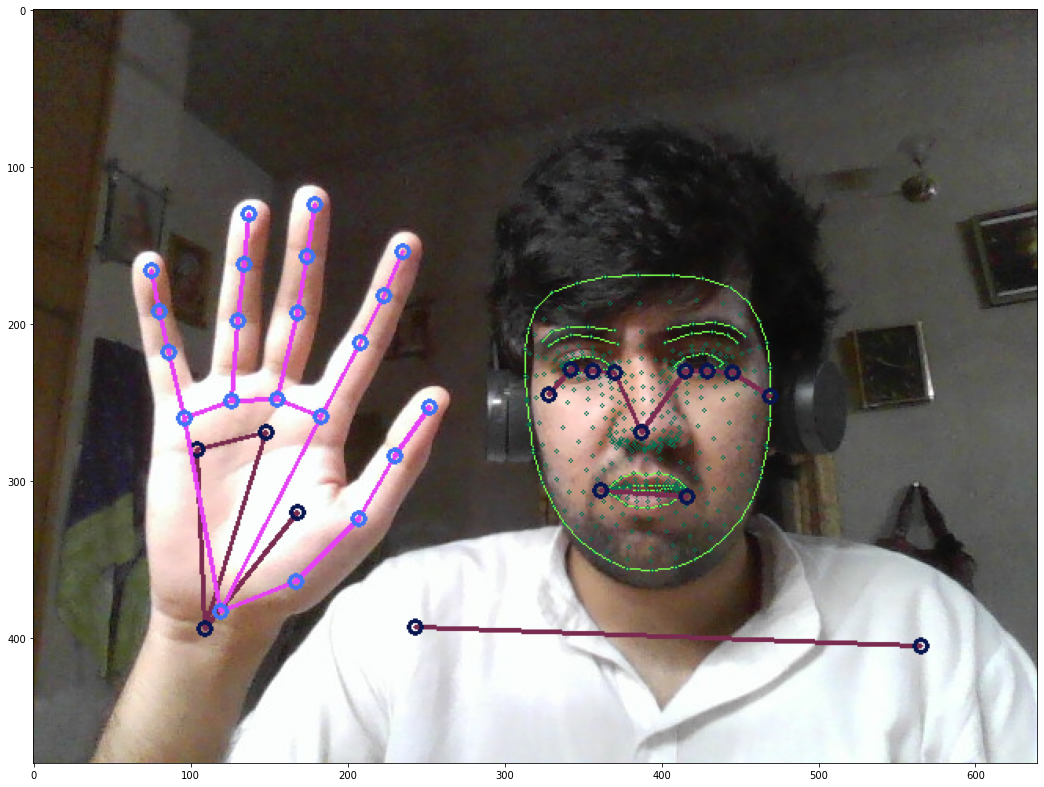

In [7]:
# last Frame Seen to show the keypoints being mapped successfully ()
plt.figure(figsize=(18,18))
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

# 3) Key-Point Extraction

In [8]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])
# if the landmarks are not available for left hand or Right hand we add zeros array for 21 landmarks by 3 coordinates each, same goes for the face and pose
# pose has 4 landmarks, x,y,z and visibility

In [9]:
result_test = extract_keypoints(results)
result_test.shape

(1662,)

#### From above cell we can say that we have 1662 total keypoints being tracked and extracted

# 4) Setting Up Folders For Collection Of Keypoints

In [10]:
# Path for exported data and the numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['hello', 'thanks', 'iloveyou'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# In this action detection I am using 30 different sets of preceding keypoints(1662) to classify an action rather using a single frame to classify an action
# i.e. a sequnece of data is being used

In [11]:
# 3 folders for each action and in each action there will be 30 folders (0 to 29) each containing a video of 30 frames stored as a numpy array
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# 5) Collecting Keypoints for Training and Testing 

In [12]:
# Collecting 30 Videos of size 30 frames for 3 handsigns and in each frame there are 1662 keypoints in one frame
cap = cv2.VideoCapture(1)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    # Loop through actions
    for action in actions:
        # Loop through sequences(videos)
        for sequence in range(no_sequences):
            # Loop through video length (sequence length)
            for frame_num in range(sequence_length):
                # Read feed
                ret, frame = cap.read()
                # Make detections
                image, results = mediapipe_detection(frame, holistic)
                # Draw landmarks
                draw_styled_landmarks(image, results)
                # Wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)# 2 second break
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('Data Collection HSD', image)
                # Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)
                # Break out of loop
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

# 6) Data Preprocessing, Creating Labels and Features

In [12]:
# Creating a Dictionary to represent all the Labels/Actions/Handsigns
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [13]:
# Bringing data together and structuring it (90 arrays with 30 frames in each of those arrays with 1662 values which represent the key points in each label)

sequences, labels = [], []
# sequences is for the feature data (x data) and labels is for the labels(actions)(y data)

# Looping for each action(handsign)
for action in actions: 
    
    # looping in all 30 videos per action
    for sequence in range(no_sequences):
        # Windows represents all the different frames that are there for the particular sequence
        window = []
        
        # Looping through each of the frames (30 frames)
        for frame_num in range(sequence_length):
            
             # Loading each of the frame using np.load as we saved as np array
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            
            window.append(res) # Adding all 30 frames of each action in subsequent iterations
        
        # Once we have all the 30 frames we append it to the sequences
        sequences.append(window) 
        labels.append(label_map[action])

In [14]:
x = np.array(sequences)
x.shape

(90, 30, 1662)

x has 90 videos with 30 frames in each of those videos with 1662 values which represent our keypoints

In [15]:
np.array(labels).shape

(90,)

We get 90 labels (30 per video)

In [16]:
y = to_categorical(labels).astype(int) # One hot encoded representation of labels
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

In [17]:
y.shape

(90, 3)

The above to cells provide with one hot encoded representation of labels ( 3 labels and 30 per action)

### Performing Training and Test split of the data

In [30]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.05)

In [31]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((85, 30, 1662), (5, 30, 1662), (85, 3), (5, 3))

The reason for taking only 5% of the data for test is because of lack of available data for each action, so if we use a standard test train split of 70-30 or 60-40 etc. Due to lack of available data the LSTM model will not be able to train properly and will not perform well in real time predictions.
NOTE: In case we have more data while executing this notebook we can increase the test size to a standard partition if there is adequate data available.

# 7) Building and Training LSTM Model

In [32]:
# Setup for Tesnsorboard so that Training of model can be monitored in real time
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [33]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [34]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# Loss can be categorical crossentropy only because we have multi class classification model

In [35]:
# Using media pipe holisitc model allows more often the model to fit into your memory, which eliminates the need for data generator, pipeline of data
model.fit(x_train, y_train, epochs=200, callbacks=[tb_callback])

Epoch 1/200
3/3 [==============================] - 3s 562ms/step - loss: 4.3048 - categorical_accuracy: 0.3176
Epoch 2/200
3/3 [==============================] - 1s 227ms/step - loss: 4.5959 - categorical_accuracy: 0.3529
Epoch 3/200
3/3 [==============================] - 1s 230ms/step - loss: 2.8102 - categorical_accuracy: 0.3529
Epoch 4/200
3/3 [==============================] - 1s 246ms/step - loss: 3.1707 - categorical_accuracy: 0.3647
Epoch 5/200
3/3 [==============================] - 1s 232ms/step - loss: 5.8480 - categorical_accuracy: 0.2824
Epoch 6/200
3/3 [==============================] - 1s 252ms/step - loss: 11.9652 - categorical_accuracy: 0.2824
Epoch 7/200
3/3 [==============================] - 1s 252ms/step - loss: 5.9882 - categorical_accuracy: 0.3529
Epoch 8/200
3/3 [==============================] - 1s 246ms/step - loss: 6.7927 - categorical_accuracy: 0.3529
Epoch 9/200
3/3 [==============================] - 1s 230ms/step - loss: 1.5466 - categorical_accuracy: 0.3176


In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 30, 64)            442112    
_________________________________________________________________
lstm_7 (LSTM)                (None, 30, 128)           98816     
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 99        
Total params: 596,675
Trainable params: 596,675
Non-trainable params: 0
________________________________________________

### From the above model summary we clearly see the advantage of using Mediapipe Holistic + LSTM Model<br>
1) Less data is required to produce a very accurate model.<br>
2) It comprises of a much denser neural network which is faster to train compared to some other state of the art model to train.<br>
3) Where models using CNN and LSTM and many more require a lot of data and around 30 to 40 million parameters to train our model uses only half million parameters (approx).<br>
4) It results in a faster detection due to the use of a simple neural network.

# 8)  Static Predictions

In [37]:
res = model.predict(x_test)

In [38]:
actions[np.argmax(res[1])]

'hello'

In [39]:
actions[np.argmax(y_test[1])]

'hello'

# 9) Saving Weights

In [40]:
model.save('HSD_Ver1.h5')

# 10) Model Evaluation

In [41]:
yhat = model.predict(x_test)

In [42]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [43]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[2, 0],
        [0, 3]],

       [[4, 0],
        [0, 1]],

       [[4, 0],
        [0, 1]]], dtype=int64)

The Multilabel Confusion Matrix  function returns a returns a confusion matrix sorted by the label order(0,1,2 i.e. "hello","Thank you","I love you")<br>
The matrix is organized as:<br>
[True Negative , False Positive<br>
False Negative, True Positive]<br>
We basically aim for two things here:<br>
1) All the numbers are in top left and bottom right <br>
2) Lower the number better is the model

In [44]:
accuracy_score(ytrue, yhat)

1.0

The reason for this 100% accuracy is because we did not have a enough data for testing our model, but that does not mean that it has trained even on outliers which can be confirmed by running the accuracy check for training data, it is done just to show that our model has learnt properly and has not overfitted

In [45]:
yhat = model.predict(x_train)
ytrue = np.argmax(y_train, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [46]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[58,  0],
        [ 1, 26]],

       [[56,  0],
        [ 2, 27]],

       [[53,  3],
        [ 0, 29]]], dtype=int64)

In [47]:
accuracy_score(ytrue, yhat)

0.9647058823529412

From the above cells we can confirm that our model is not overfitted or underfitted in any manner and is performing reasonably well for the limited data available to it.

# 11) Real Time Prediction

In [48]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [58]:
sequence = []
sentence = []
predictions = []
threshold = 0.8

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:] # we need to grab the last 30 frames for our predictions
        
        # Performing predictions only when 30 frames have been captured
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Visulization logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Visualisation probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('Hand Sign Predictor', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

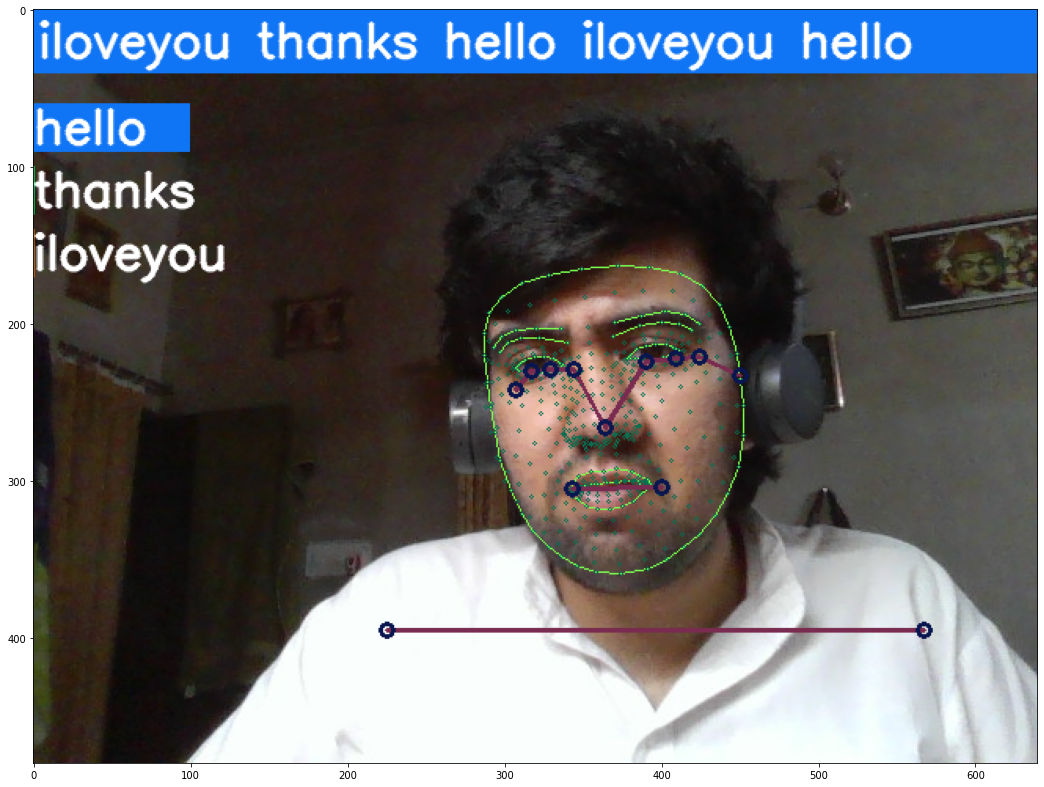

In [59]:
plt.figure(figsize=(18,18))
img = prob_viz(res, actions, image, colors)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))